# Model Evaluation
This notebook is made to evaluate models, without having to have the specific, model defined. 

The current version is made to work well with the segmentation exercise.

This uses TorchScript, which is a compiled version of our model. 

In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image

# pip install torchsummary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time

import matplotlib.pyplot as plt
from IPython.display import clear_output
import torchvision.transforms as TF
import torch.nn.functional as F

# Dataloaders
from retinal_loaders import DRIVEDataLoader, PATCH_DRIVEDataLoader
from loss_functions import dice_loss, bce_loss, focal_loss



In [18]:
size = 128
test_transform = transforms.Compose([
    transforms.Resize((512, 512)), 
                                    transforms.ToTensor()])
data_path = '/dtu/datasets1/02516/phc_data'
#data_path = './phc_data'


batch_size = 1
testset = PATCH_DRIVEDataLoader(train=True, transforms=test_transform, crop_size=None)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=1)


## Load Model

In [19]:
def model_info(model):
    for name, param in model.named_parameters():
        print(f"Layer: {name}")
        print(f"Size: {param.size()}")
        print(f"Number of parameters: {param.numel()}")
        print('-' * 40)

# Choose device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# We can load our compiled model using
model = torch.jit.load('model.pt')
model.eval()
model_info(model)

Layer: layer0.0.weight
Size: torch.Size([128, 3, 3, 3])
Number of parameters: 3456
----------------------------------------
Layer: layer0.0.bias
Size: torch.Size([128])
Number of parameters: 128
----------------------------------------
Layer: layer0.1.weight
Size: torch.Size([128])
Number of parameters: 128
----------------------------------------
Layer: layer0.1.bias
Size: torch.Size([128])
Number of parameters: 128
----------------------------------------
Layer: layer0.3.weight
Size: torch.Size([128, 128, 3, 3])
Number of parameters: 147456
----------------------------------------
Layer: layer0.3.bias
Size: torch.Size([128])
Number of parameters: 128
----------------------------------------
Layer: layer0.4.weight
Size: torch.Size([128])
Number of parameters: 128
----------------------------------------
Layer: layer0.4.bias
Size: torch.Size([128])
Number of parameters: 128
----------------------------------------
Layer: pool0.weight
Size: torch.Size([256, 128, 3, 3])
Number of paramet

## Evaluation

(1, 1, 512, 512)
8
8
tensor(57555.5859)
tensor(115295.3359)
tensor(171505.2812)
tensor(232472.1094)
tensor(303893.0625)
tensor(371191.0625)
tensor(428746.6562)
tensor(486302.2500)
tensor(543324.0625)
tensor(611358.6250)
tensor(716893.8125)
tensor(815389.6875)
tensor(890663.8750)
tensor(958882.3125)
tensor(1047012.5000)
tensor(1104953.2500)
tensor(1174922.5000)
tensor(1309012.)
tensor(1422674.1250)
tensor(1512553.3750)
tensor(1580793.3750)
tensor(1647692.1250)
tensor(1690161.6250)
tensor(1778612.7500)
tensor(1898548.1250)
tensor(1984324.3750)
tensor(2073847.5000)
tensor(2148662.7500)
tensor(2221512.5000)
tensor(2286134.2500)
tensor(2332829.5000)
tensor(2417814.2500)
tensor(2487695.5000)
tensor(2606604.7500)
tensor(2715221.)
tensor(2780361.7500)
tensor(2850682.)
tensor(2902521.)
tensor(2953973.5000)
tensor(3024815.7500)
tensor(3094975.2500)
tensor(3183408.)
tensor(3301903.7500)
tensor(3401188.7500)
tensor(3499494.7500)
tensor(3573717.)
tensor(3628754.2500)
tensor(3695997.)
tensor(3753313

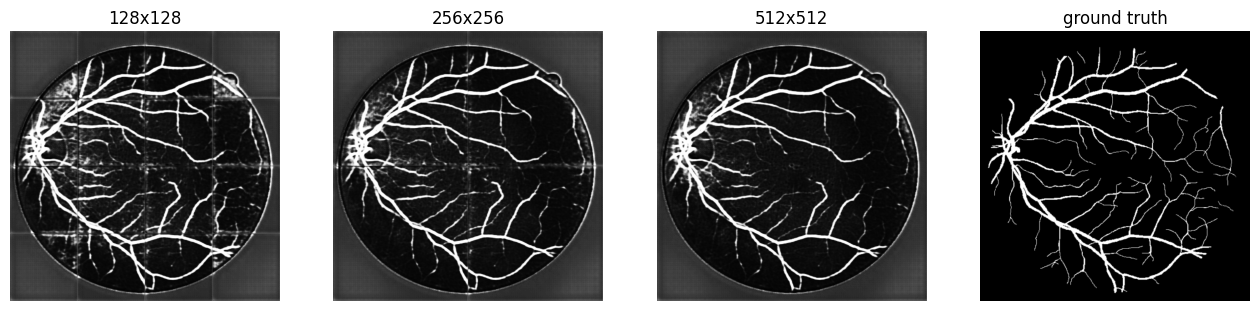

In [20]:
def evaluate_images_patched(image, target, model, crop_size,device='cpu'):
    image = image.to(device)  # Move input to the correct device
    model = model.to(device)
    
    image_size = np.array(target.cpu()).shape # image is a tensor of shape (B, C, W, H)
    print(image_size)
    x_splits = (int)(image_size[2] / crop_size[0]) 
    y_splits = (int)(image_size[3] / crop_size[1])
    
    batch_size = image_size[0]
    
    output_images = torch.zeros(image_size)
    
    avg_loss = 0
    model.eval()
    x_size = crop_size[0]
    y_size = crop_size[1]
    
    
    print(x_splits)
    print(y_splits)
    for x in range(x_splits):
        for y in range(x_splits):
            main_image = TF.functional.crop(image,    x*x_size,y*y_size,x_size,y_size)
            
            pred = model(main_image)
            loss = torch.sigmoid(pred).detach().cpu()
            

            output_images[:, :, x*x_size:x*x_size+x_size, y*y_size: y*y_size+y_size] = loss
            avg_loss += loss.sum() / batch_size*x_splits*y_splits
            print(avg_loss)
            del main_image
    
    return output_images ,avg_loss




def evaluate_model(model, loss_fn, test_loader, device="cuda"):
    avg_loss = 0
    model = model.to(device)
    model.eval()        
    for X_batch, Y_batch in test_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        # forward
        Y_pred = model(X_batch)
        loss = loss_fn(Y_batch, Y_pred)  # forward-pass

        # calculate metrics to show the user
        avg_loss += loss.item() / len(test_loader)
        
        
        del X_batch
        del Y_batch
    X_test, Y_test = next(iter(test_loader))
    model.to("cpu")
    # show intermediate results
    Y_hat = torch.sigmoid(model(X_test.to("cpu"))).detach().cpu()
    clear_output(wait=True)
    count = 1
    print(X_test[0].numpy().shape)
    for k in range(count):
        plt.subplot(1, 2, k+1)
        plt.imshow(np.rollaxis(X_test[k].numpy(), 0, 3), cmap='gray')
        plt.title('Real')
        plt.axis('off')

        plt.subplot(1, 2, k+count*1+1)
        plt.imshow(Y_hat[k, 0], cmap='gray')
        plt.title('Output')
        plt.axis('off')
    plt.suptitle('- loss: %f' % ( avg_loss))
    plt.show()

# evaluate_model(model, focal_loss, test_loader=test_loader)
image = next(iter(test_loader))

main = image[0][:]
secondary = image[1][:]

transform = TF.ToPILImage()

size64 = 64
size128 = 128
size256 = 256
size512 = 512


images64, _ = evaluate_images_patched(main, secondary, model, crop_size=(size64,size64),device="cuda" )
images128, _ = evaluate_images_patched(main, secondary, model, crop_size=(size128,size128),device="cuda" )
images256, _ = evaluate_images_patched(main, secondary, model, crop_size=(size256,size256),device="cuda" )
images512, _ = evaluate_images_patched(main, secondary, model, crop_size=(size512,size512),device="cuda" )


fig, axs = plt.subplots(1, 4, figsize=(16, 4))  # You can change (1, 4) to (2, 2) for a 2x2 grid

# Display each image in a subplot
axs[0].imshow(transform(images128[0]), cmap="gray")
axs[0].set_title('128x128')
axs[0].axis('off')

axs[1].imshow(transform(images256[0]), cmap="gray")
axs[1].set_title('256x256')
axs[1].axis('off')

axs[2].imshow(transform(images512[0]), cmap="gray")
axs[2].set_title('512x512')
axs[2].axis('off')

axs[3].imshow(transform(secondary[0]), cmap="gray")
axs[3].set_title('ground truth')
axs[3].axis('off')

# Display the full figure
plt.show()


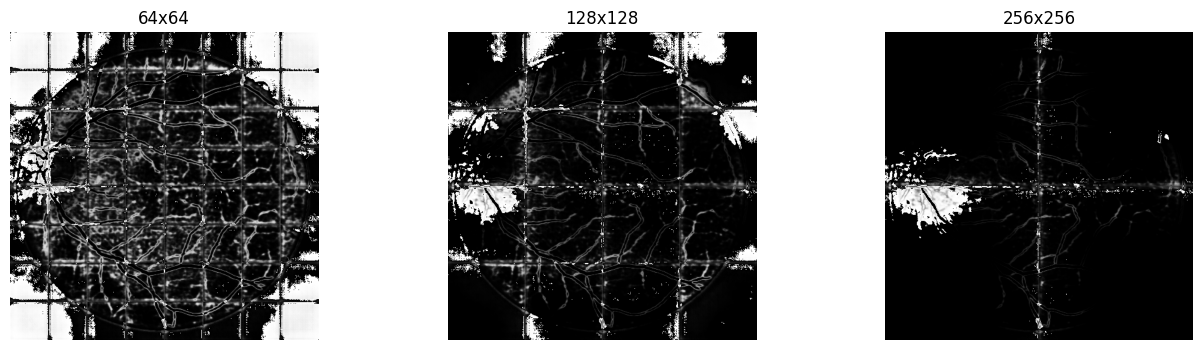

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))  # You can change (1, 4) to (2, 2) for a 2x2 grid

diff1 = images64[0] - images512[0]
diff2 = images128[0] - images512[0]
diff3 = images256[0] - images512[0]

# Display each image in a subplot
axs[0].imshow(transform(diff1), cmap="gray")
axs[0].set_title('64x64')
axs[0].axis('off')  # Turn off axis labels

axs[1].imshow(transform(diff2), cmap="gray")
axs[1].set_title('128x128')
axs[1].axis('off')

axs[2].imshow(transform(diff3), cmap="gray")
axs[2].set_title('256x256')
axs[2].axis('off')



# Display the full figure
plt.show()